# Import

## Modules

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from datetime import timedelta, datetime
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Setup figure plot settings

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
sns.set_palette("deep")

 Setup paths to import scripts

In [3]:
PROJECT_ROOT = Path.cwd().parent.resolve()
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [4]:
from src.data.make_dataset import make_cases_training_data, make_train_test_split, get_prior_distr_params

## Data

In [5]:
data = make_cases_training_data()

## Audit

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   notification_date       56 non-null     datetime64[ns]
 1   Daily Number of Cases   56 non-null     int64         
 2   Cumsum                  56 non-null     int64         
 3   Daily Difference        55 non-null     float64       
 4   Growth Factor           54 non-null     float64       
 5   Weekly Rolling Average  50 non-null     float64       
 6   Pct Change              49 non-null     float64       
 7   Weekly Average CumSum   50 non-null     float64       
 8   Epidemiological Days    56 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 6.4 KB


In [7]:
data

,notification_date,Daily Number of Cases,Cumsum,Daily Difference,Growth Factor,Weekly Rolling Average,Pct Change,Weekly Average CumSum,Epidemiological Days
0,2021-06-16,3,3,NaN,NaN,NaN,NaN,NaN,-24.0
1,2021-06-17,1,4,-2.0,NaN,NaN,NaN,NaN,-23.0
2,2021-06-18,2,6,1.0,-0.500000,NaN,NaN,NaN,-22.0
3,2021-06-19,1,7,-1.0,-1.000000,NaN,NaN,NaN,-21.0
4,2021-06-20,2,9,1.0,-1.000000,NaN,NaN,NaN,-20.0
5,2021-06-21,5,14,3.0,3.000000,NaN,NaN,NaN,-19.0
6,2021-06-22,17,31,12.0,4.000000,4.0,NaN,4.0,-18.0
7,2021-06-23,12,43,-5.0,-0.416667,6.0,0.500000,10.0,-17.0
8,2021-06-24,21,64,9.0,-1.800000,9.0,0.500000,19.0,-16.0
9,2021-06-25,28,92,7.0,0.777778,12.0,0.333333,31.0,-15.0


# Split Data

In [8]:
train_size = 0.8
X_train, X_test, y_train, y_test = make_train_test_split(data, train_size=train_size)

Get prior distribution parameters

In [9]:
initial_number_of_cases, daily_number_of_cases_std, average_pct_change, std_pct_change = get_prior_distr_params(y_train)
print(f"Number of cases at the start of the time series: {initial_number_of_cases}")
print(f"Daily number of cases standard deviation: {daily_number_of_cases_std}")
print(f"Average percentage change: {average_pct_change}")
print(f"Standard deviation of percentage change: {std_pct_change}")

Number of cases at the start of the time series: 45.0
Daily number of cases standard deviation: 73.19873222945873
Average percentage change: 0.2596077420114976
Standard deviation of percentage change: 0.7791709860222373


# Model Training

## Train Model

In [10]:
# Create PyMC3 context manager
with pm.Model() as model:

    # Setup data for the model
    t = pm.Data("X", X_train)
    cases = pm.Data("y", y_train)

    # Intercept
    a = pm.Normal("a", mu=initial_number_of_cases, sigma=daily_number_of_cases_std)

    # Slope 
    b = pm.Normal("b", mu=average_pct_change, sigma=std_pct_change)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so Poisson or negative binomial, but they causes issues.
    # Independence hypothesis is violated, due to transmission between people.
    # Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample(1000, tune=2000, cores=5, return_inferencedata=True)
    post_Pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [eps, b, a]


Sampling 5 chains for 2_000 tune and 1_000 draw iterations (10_000 + 5_000 draws total) took 12 seconds.


## Model Evaluation

In [11]:
# Update data reference.
pm.set_data({"X": X_test}, model=model)

# Generate posterior samples
post_pred_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Get test prediction datam

In [12]:
y_pred = np.mean(post_pred_test["cases"], axis=0)
y_std = np.std(post_pred_test["cases"], axis=0)

Define custom metrics for model performance evaluation

In [13]:
def point_set_distance(y_pred: np.ndarray, y_pred_std: np.ndarray, y_true: np.ndarray
                        ) -> np.ndarray:
    """Compute the point-to-set distance between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        np.ndarray: point-to-set distance: Numpy array.

    References:
        [1] https://math.stackexchange.com/questions/2099527/distance-between-a-point-and-a-set-or-closure-of-it
    """
    assert y_pred.shape == y_true.shape, "The shapes of the predicted and true values do not match."
    assert y_pred.shape == y_pred_std.shape, "The shapes of predicted and std values do not match."

    return np.where(y_pred - y_pred_std <= y_true <= y_pred + y_pred_std, 0
            ,min(abs(y_true - (y_pred + y_pred_std))
                ,abs(y_true - (y_pred - y_pred_std))
                )
            )


def mean_squared_relative_error(y_pred: np.ndarray, y_true: np.ndarray
                                ,distance: str=None, y_pred_std: np.ndarray=None
                                ) -> float:
    """Compute the mean squared relative error between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        distance (str, optional): Distance metric to use. Defaults to None.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        float: mean squared relative error: Numpy array. Mean squared relative error between the predicted and true values.

    References:
        [1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t
    """
    if distance == "point to set":
        d = point_set_distance(y_pred, y_pred_std, y_true)

    else:
        d = y_pred - y_true

    return (d**2/y_true**2).mean()


def relative_mean_squared_error(y_pred: np.ndarray, y_true: np.ndarray
                                ,distance: str=None, y_pred_std: np.ndarray=None
                                ) -> float:
    """Compute reative mean squared error between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        distance (str, optional): Distance metric to use. Defaults to None.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        float: Relative mean squared error between the predicted and true values.

    References:
        [1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t
    """

    if distance == "point to set":
        d = point_set_distance(y_pred, y_pred_std, y_true)

    else:
        d = y_pred - y_true

    return (d**2).mean()/(y_true**2).sum()



Calculate performance metrics

In [14]:
r2 = r2_score(y_pred, y_test)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmsre = np.sqrt(mean_squared_relative_error(y_pred, y_test))
rrmse = np.sqrt(relative_mean_squared_error(y_pred, y_test))
mae = mean_absolute_error(y_pred, y_test)
rmae = (abs(y_pred - y_test) / y_test).mean()
print(f"R2 = {r2}")
print(f"RMSE = {rmse}, RMSRE = {rmsre}, RRMSE = {rrmse}")
print(f"MAE = {mae}, RMAE = {rmae}")

R2 = 0.9872356106387604
RMSE = 7.5285941717616796, RMSRE = 0.035500060932104345, RRMSE = 0.016745556059303543
MAE = 5.532839862189434, RMAE = 0.03036295989406539


Plot residuals

<AxesSubplot:>

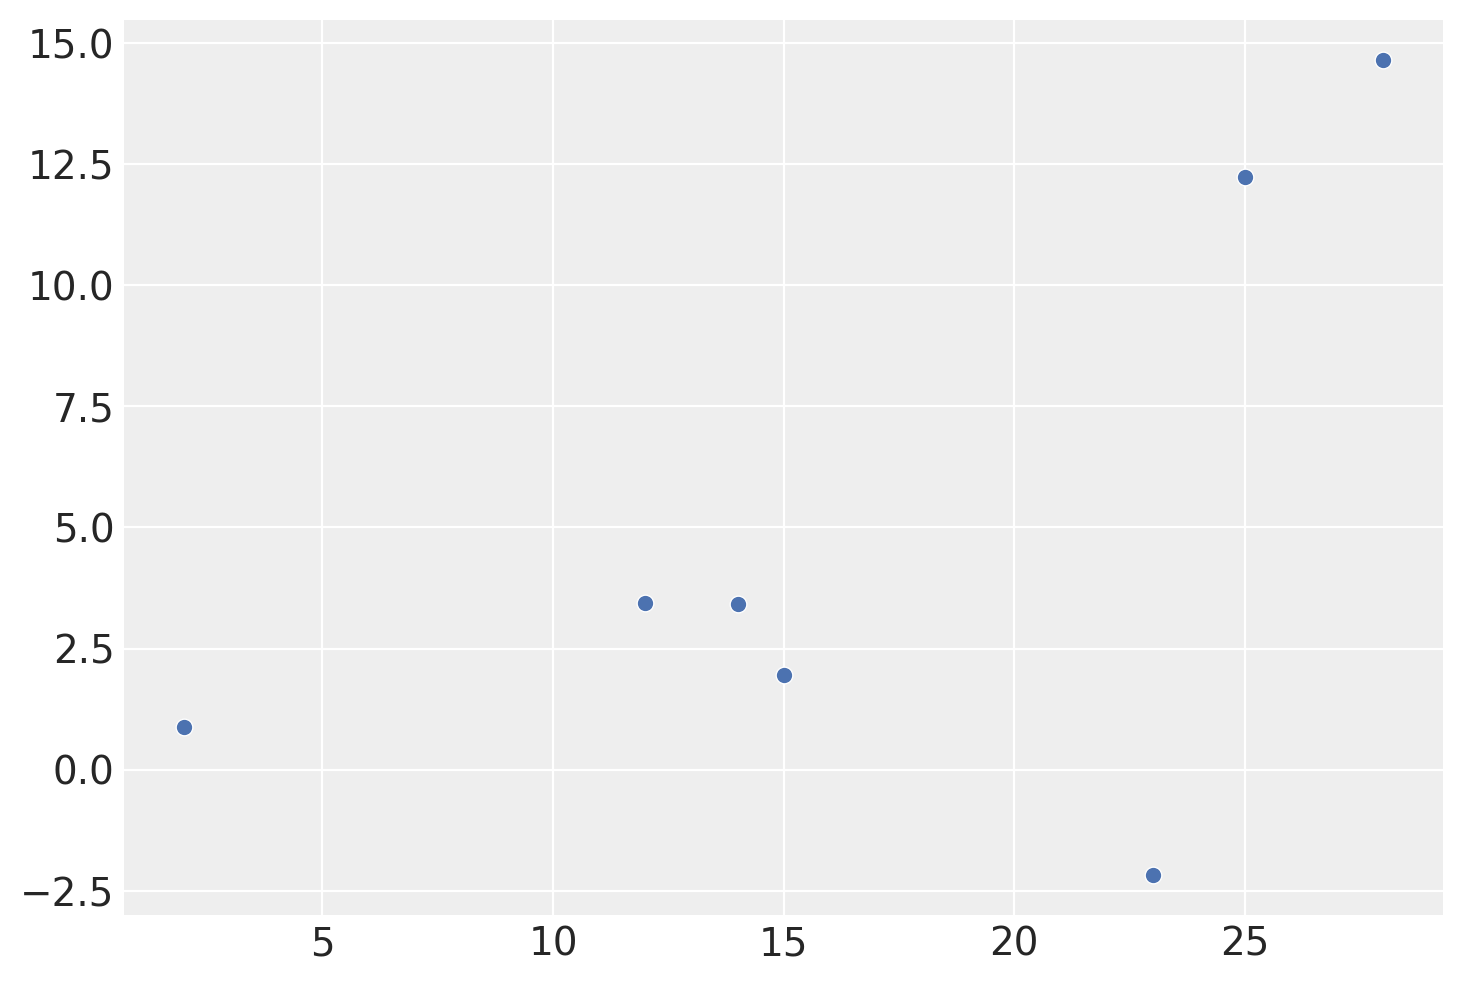

In [15]:
sns.scatterplot(x=X_test.squeeze(), y=(y_pred - y_test).squeeze(), marker="o")

# Model Inference

Distribution of model parameters

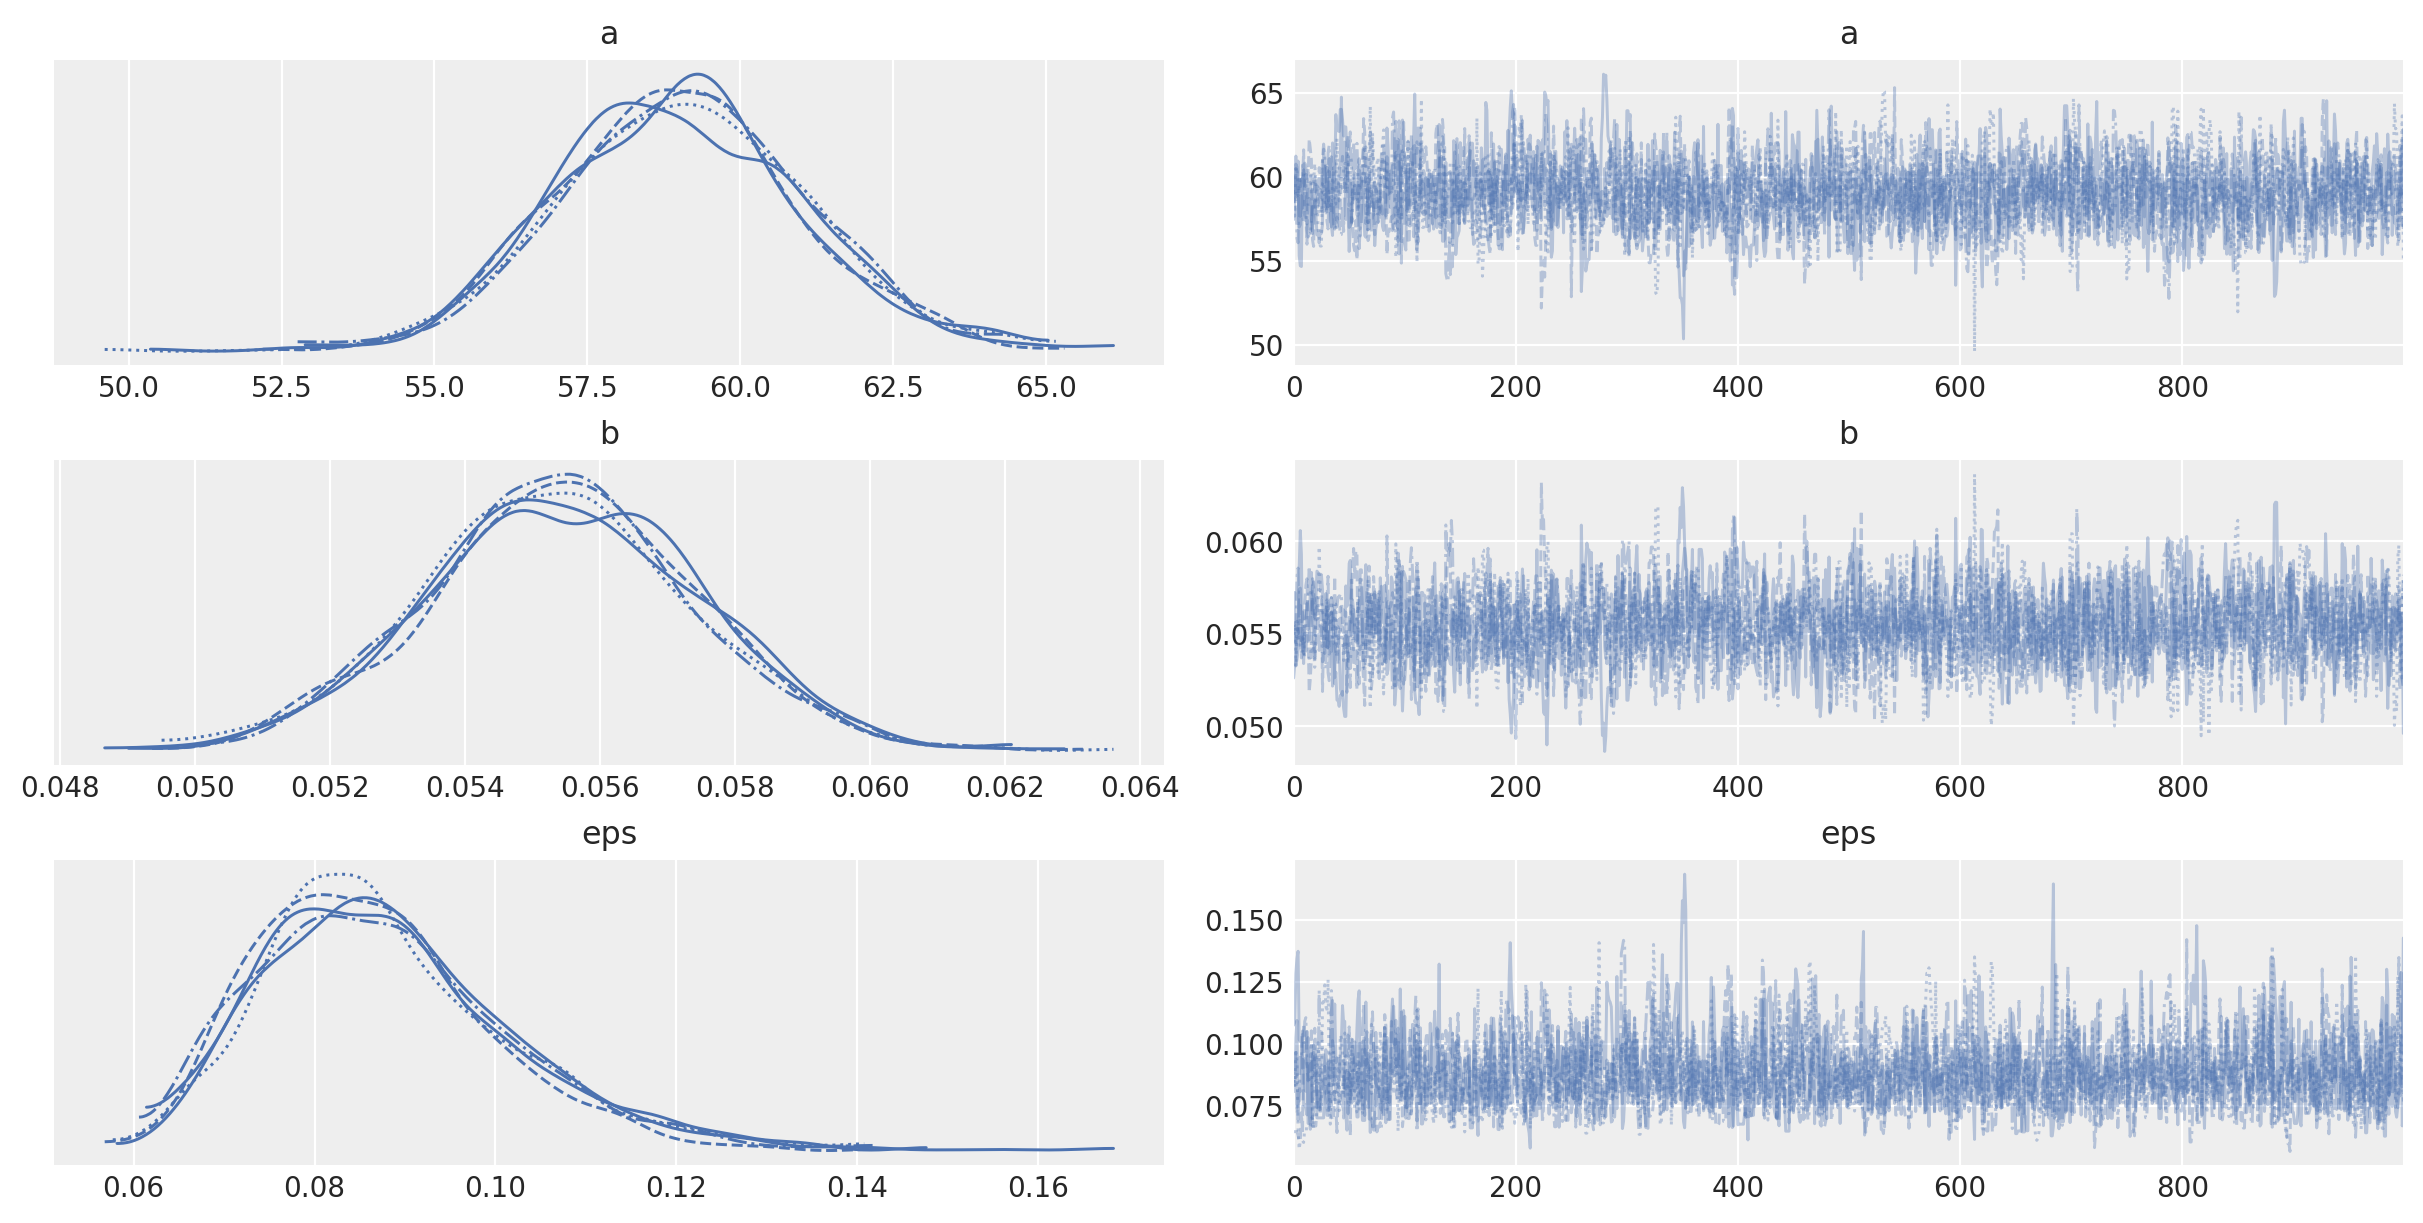

In [16]:
az.plot_trace(trace)
plt.show()

Summary of model parameters

In [17]:
pm.summary(trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,59.012,1.997,55.350,62.727,0.046,0.033,1871.0,1903.0,1.0
b,0.055,0.002,0.052,0.059,0.000,0.000,1892.0,1891.0,1.0
eps,0.088,0.014,0.064,0.113,0.000,0.000,1708.0,1625.0,1.0


## Predict on Whole Data Set

In [18]:
# Update data reference
X = np.sort(np.concatenate([X_train, X_test]).squeeze()).reshape(-1, 1)
pm.set_data({"X": X.flatten()}, model=model)

# Generate posterior samples
post_pred = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Plot model posterior predictive and actual weekly rolling average for positive values of epidemiological days

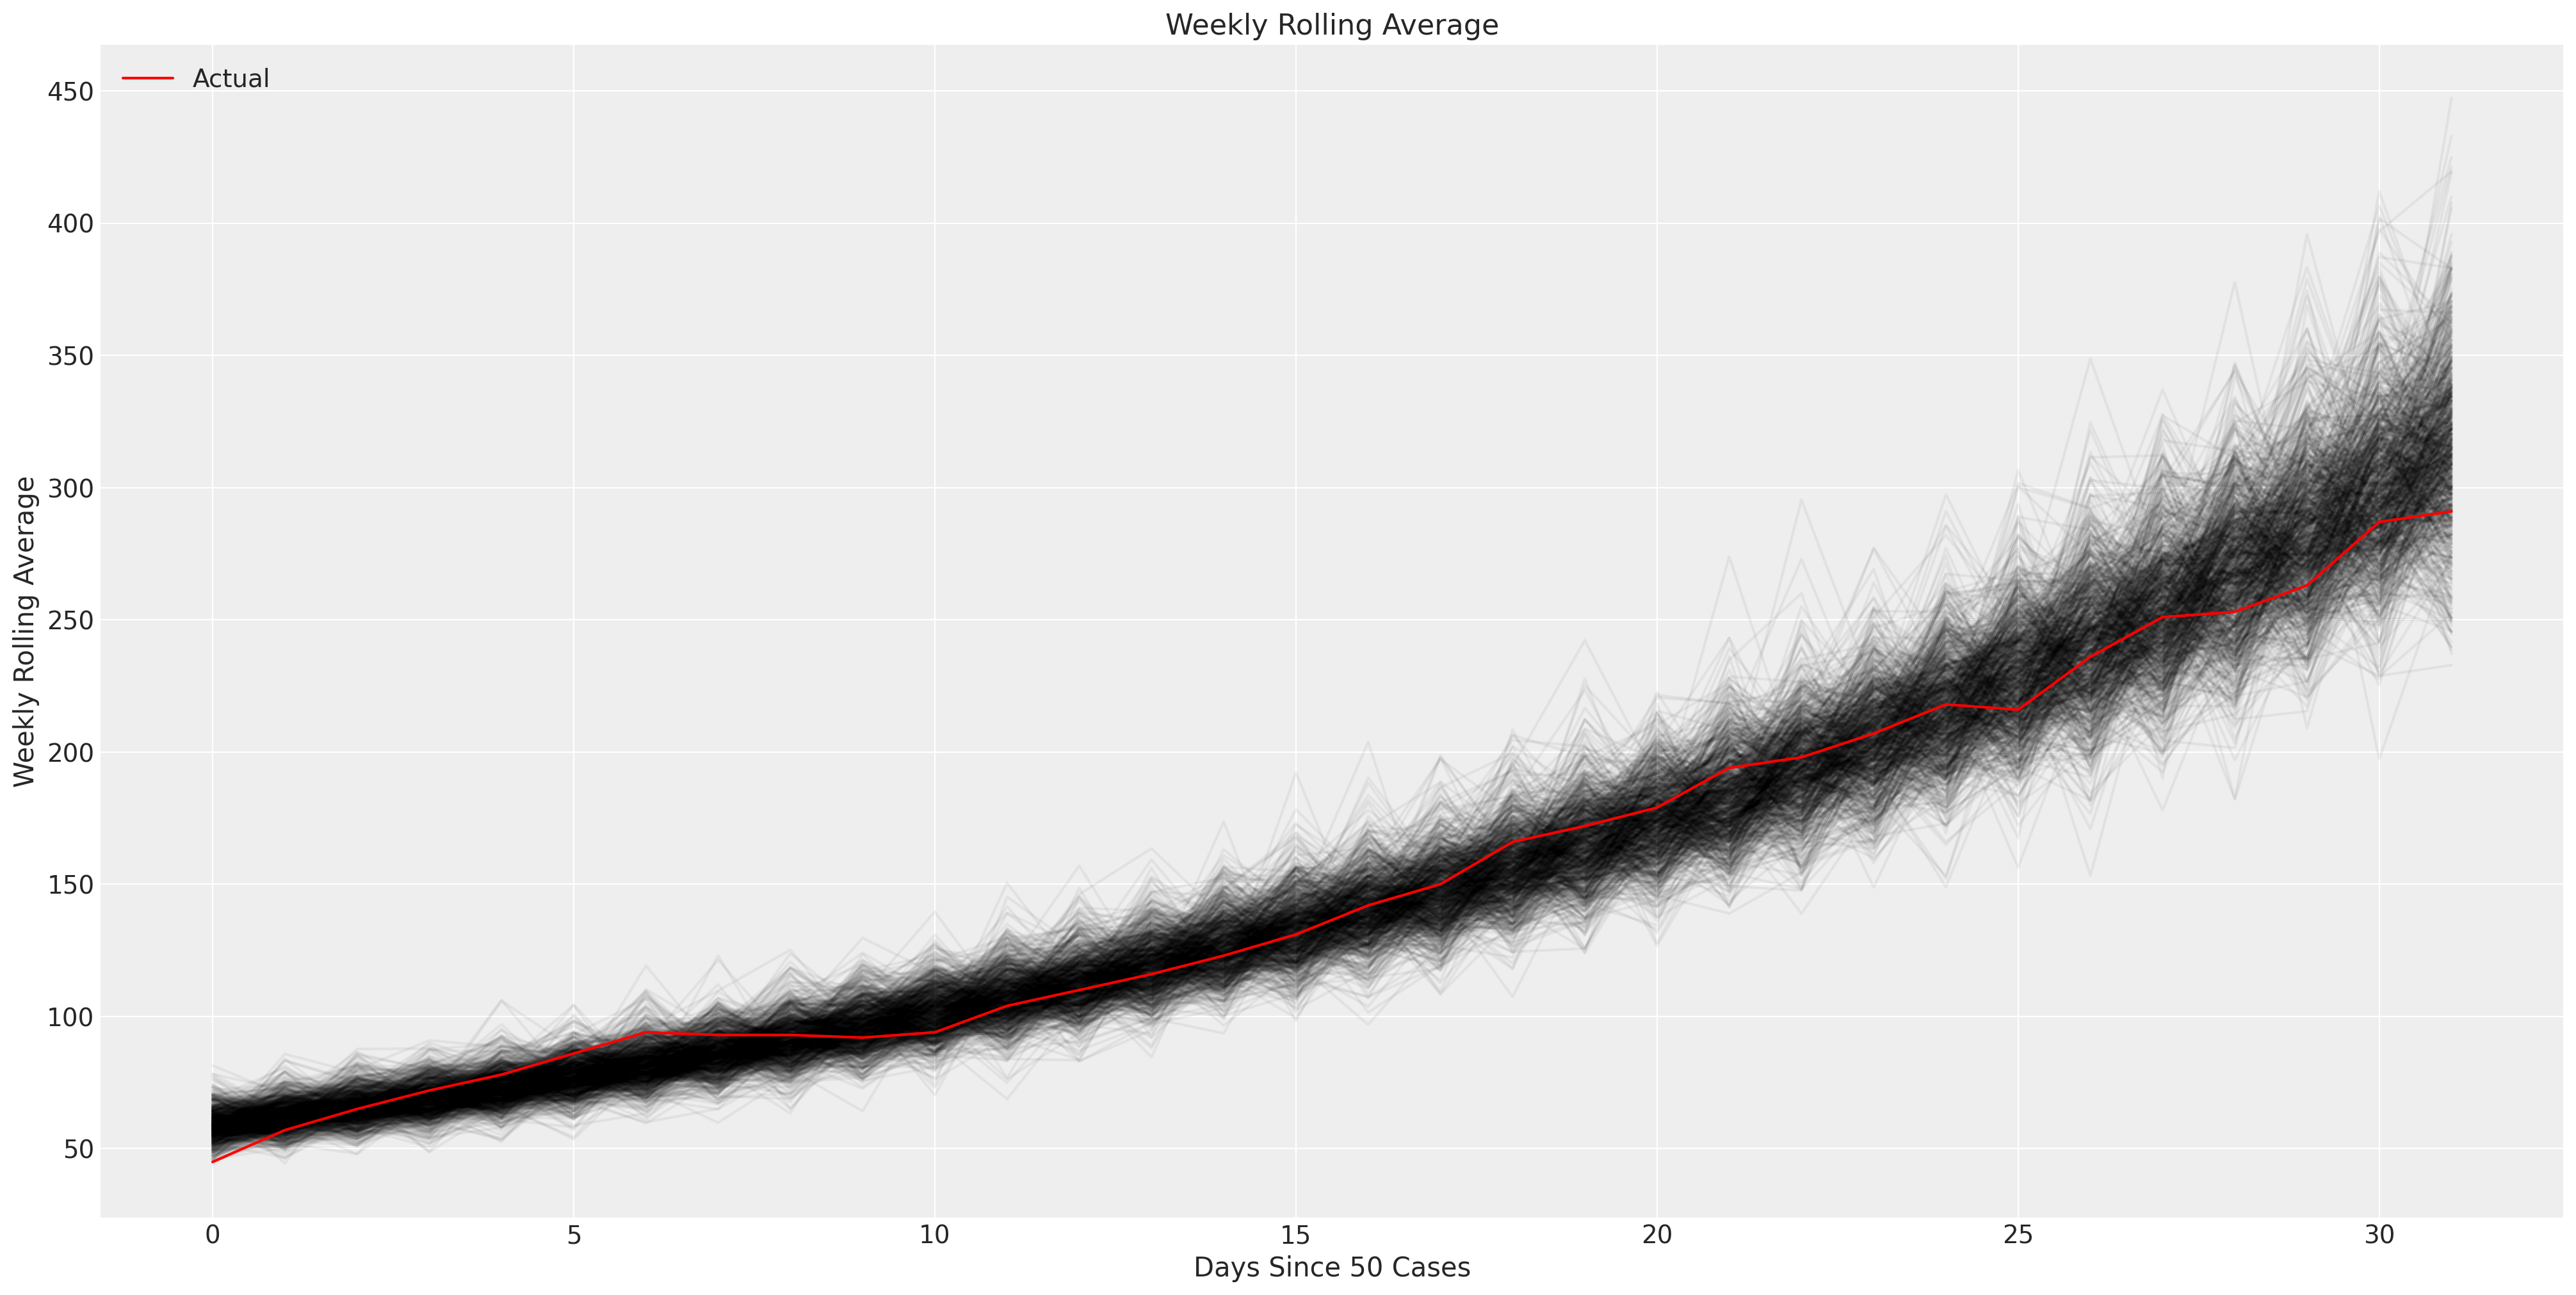

In [19]:
mask = data['Epidemiological Days'] >= 0

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X, post_pred["cases"].T, color="k", alpha=0.05)
ax.plot(X, data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
ax.set(xlabel="Days Since 50 Cases", ylabel="Weekly Rolling Average", title="Weekly Rolling Average")
ax.legend()

# Seven Days Forecast

In [20]:
# Augment epidemioligical days
forecast_ndays = 7
X_forecast = np.append(X, list(np.arange(X.max() + 1, X.max() + forecast_ndays + 1))).reshape(-1, 1)

# Update data reference.
pm.set_data({"X": X_forecast.flatten()}, model=model)

# Generate posterior samples
post_pred_forecast = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Create data set containing forecast data

In [27]:
mask = data["Epidemiological Days"] >= 0
data_forecast = pd.DataFrame({"Epidemiological Days": X_forecast.flatten()
                            ,"Weekly Rolling Average": data.loc[mask, "Weekly Rolling Average"].append(pd.Series([np.nan]*forecast_ndays))
                            ,"Daily Number of Cases": data.loc[mask, "Daily Number of Cases"].append(pd.Series([np.nan]*forecast_ndays))
                            ,"Predicted Weekly Rolling Average": np.mean(post_pred_forecast["cases"], axis=0).flatten()
                            ,"notification_date": data.loc[mask, "notification_date"].append(pd.Series([data["notification_date"].max() + timedelta(days=day) for day in range(1, forecast_ndays+1)]))
                            ,"Predicted Weekly Rolling Std": np.std(post_pred_forecast["cases"], axis=0).flatten()
                            })
data_forecast.reset_index(inplace=True, drop=True)
data_forecast["Prediction Lower Bound"] = data_forecast["Predicted Weekly Rolling Average"] - 2*data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Prediction Upper Bound"] = data_forecast["Predicted Weekly Rolling Average"] + 2*data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Forecast_On_Date"] = datetime.now().date()
data_forecast[["Predicted Weekly Rolling Average", "Prediction Lower Bound", "Prediction Upper Bound", "Forecast_On_Date", "notification_date"]].to_csv(str(PROJECT_ROOT / "data" / "processed" / f"predicted_weekly_rolling_average_{datetime.now().date()}.csv"), index=False)
data_forecast

,Epidemiological Days,Weekly Rolling Average,Daily Number of Cases,Predicted Weekly Rolling Average,notification_date,Predicted Weekly Rolling Std,Prediction Lower Bound,Prediction Upper Bound,Forecast_On_Date
0,0.0,45.0,103.0,58.987540,2021-07-10,5.574980,47.837580,70.137501,2021-08-11
1,1.0,57.0,114.0,62.101981,2021-07-11,6.047870,50.006242,74.197721,2021-08-11
2,2.0,65.0,72.0,65.864242,2021-07-12,6.100716,53.662810,78.065673,2021-08-11
3,3.0,72.0,88.0,70.053401,2021-07-13,6.764959,56.523483,83.583319,2021-08-11
4,4.0,78.0,75.0,73.431657,2021-07-14,6.907255,59.617147,87.246167,2021-08-11
5,5.0,86.0,101.0,77.278794,2021-07-15,7.611814,62.055166,92.502422,2021-08-11
6,6.0,94.0,108.0,81.991977,2021-07-16,7.515429,66.961120,97.022834,2021-08-11
7,7.0,93.0,95.0,86.607717,2021-07-17,7.942438,70.722841,102.492593,2021-08-11
8,8.0,93.0,111.0,91.117189,2021-07-18,8.391952,74.333284,107.901093,2021-08-11
9,9.0,92.0,65.0,96.401271,2021-07-19,8.660047,79.081177,113.721366,2021-08-11


Plot actual and forecasted values

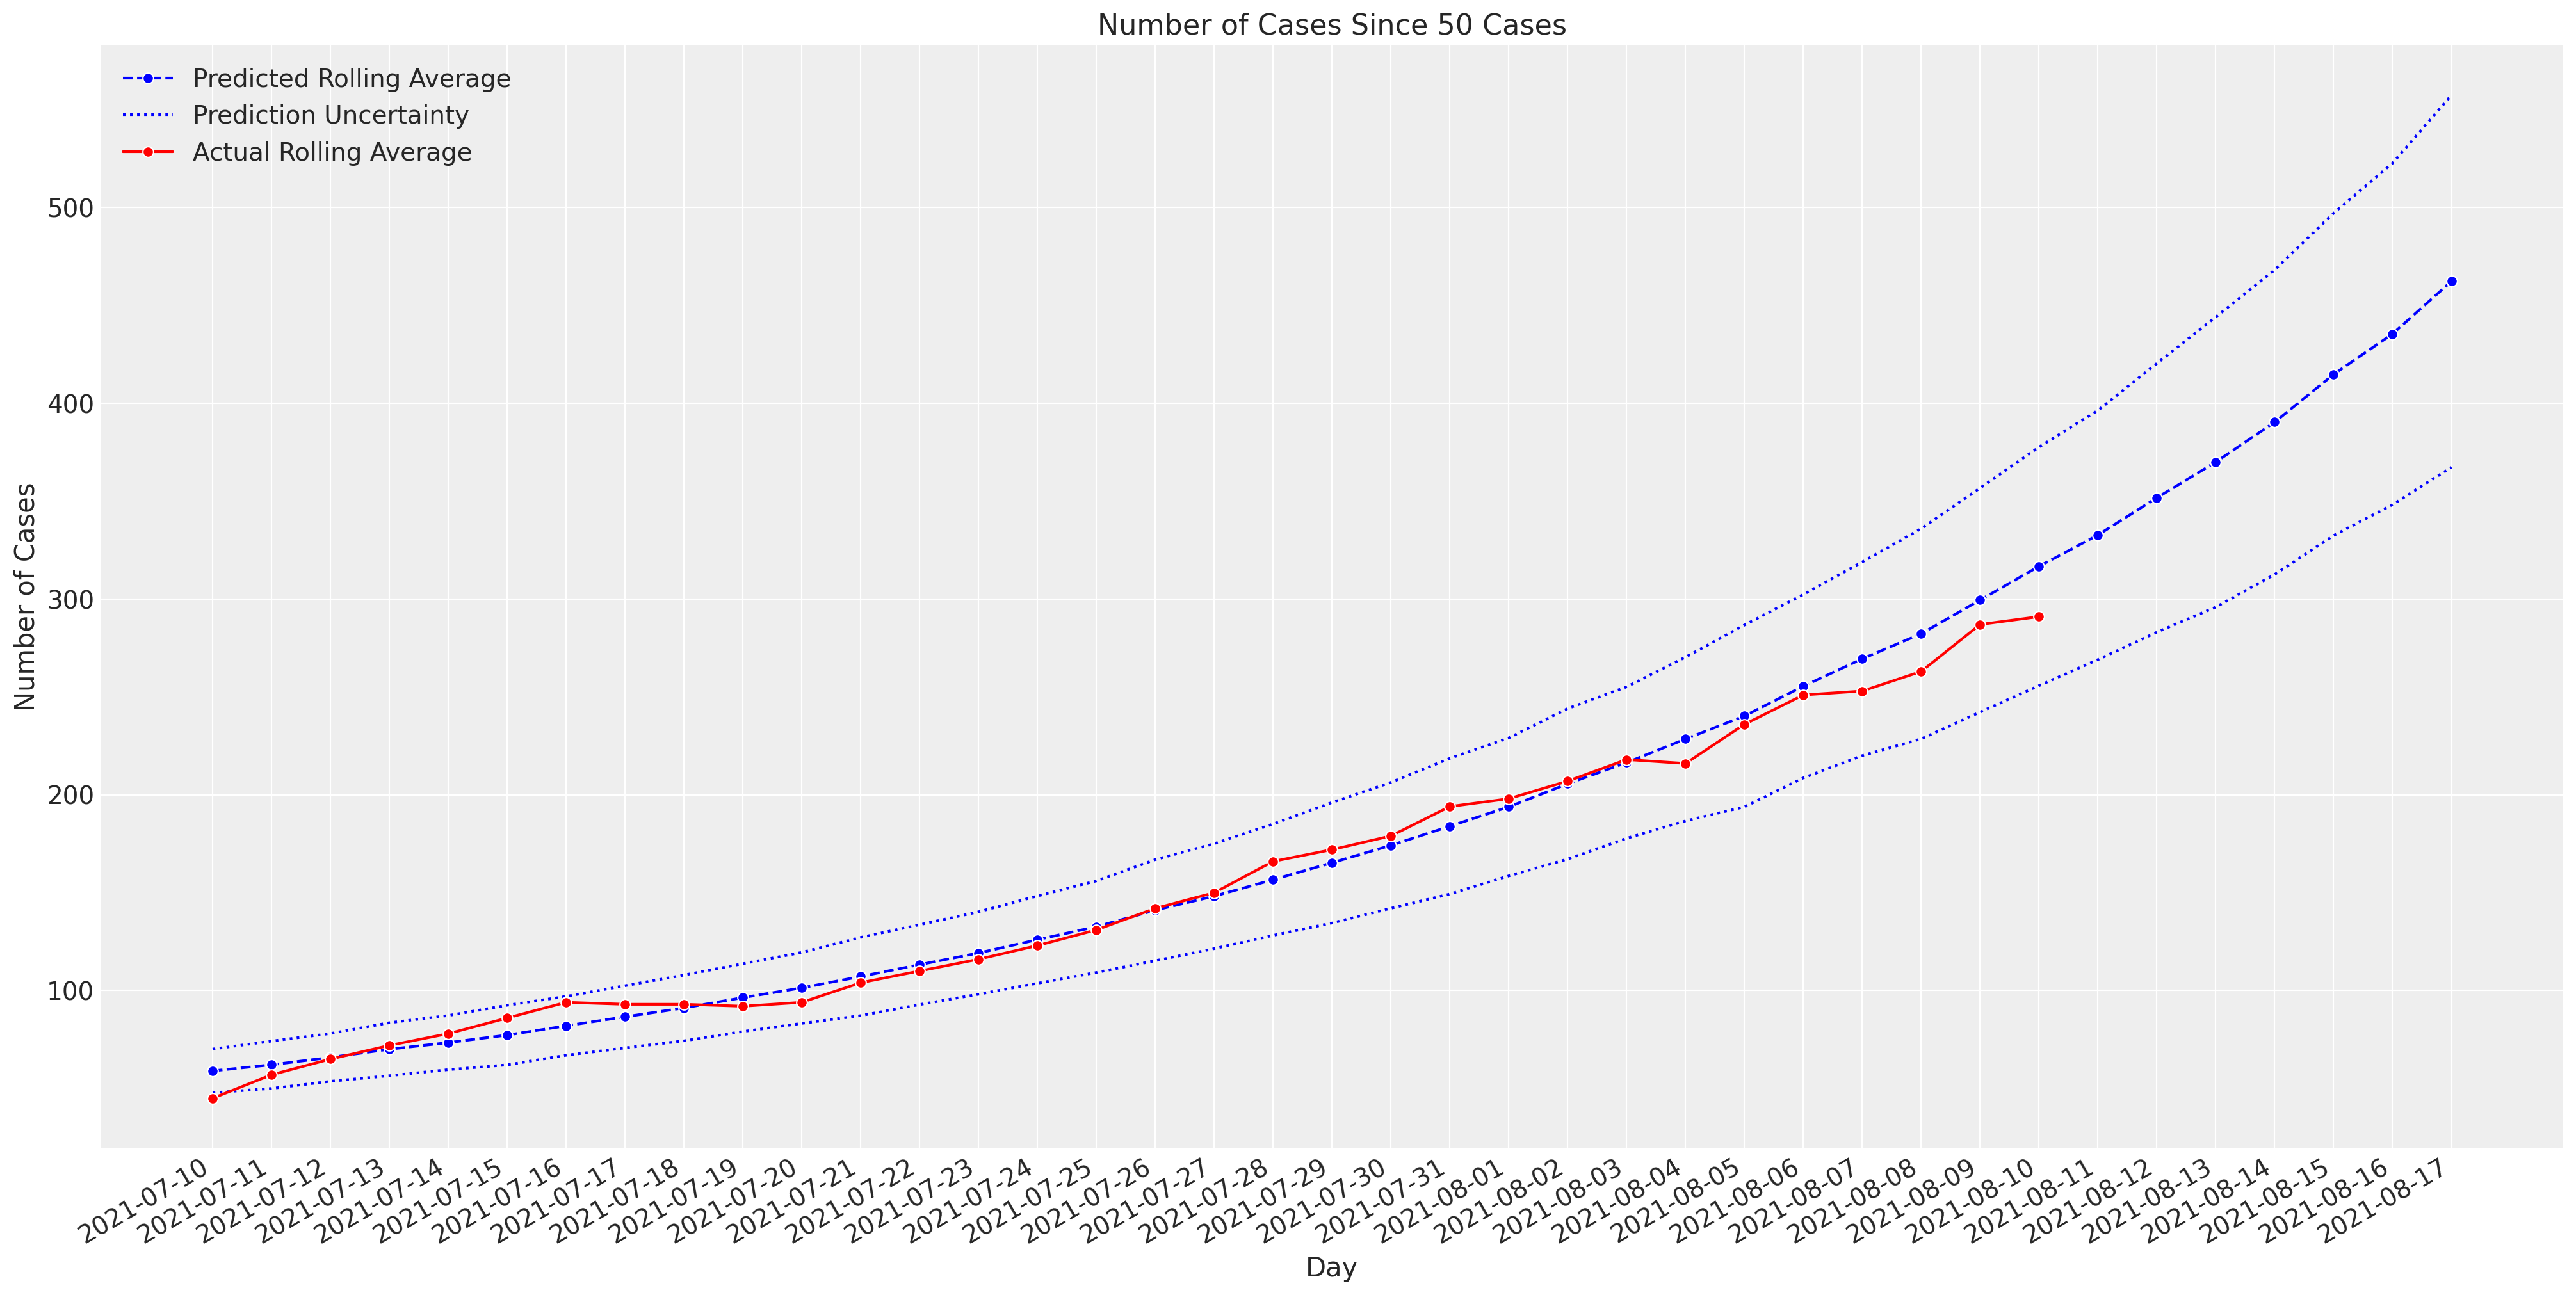

In [26]:
forecast_std = np.std(post_pred_forecast["cases"], axis=0).flatten()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"], axis=0).flatten(), color="b", marker="o", label="Predicted Rolling Average", linestyle="--", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"], axis=0).flatten() + 2*forecast_std.flatten(), color="b", linestyle=":", label="Prediction Uncertainty", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"], axis=0).flatten() - 2*forecast_std.flatten(), color="b", linestyle=":", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=data_forecast["Weekly Rolling Average"], color="r", label="Actual Rolling Average", marker="o", ax=ax)
# ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=data_forecast["Daily Number of Cases"], color="k", label="Daily Number of Cases", marker="o", ax=ax)

plt.xticks(data_forecast["Epidemiological Days"], data_forecast["notification_date"].astype(str), rotation = 30, ha="right")

ax.set(xlabel="Day", ylabel="Number of Cases", title="Number of Cases Since 50 Cases")
ax.legend()
ax.grid(True)

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Aug 11 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.25.0

numpy     : 1.19.5
matplotlib: 3.4.2
arviz     : 0.11.2
seaborn   : 0.11.1
pandas    : 1.3.0
pymc3     : 3.11.2
sys       : 3.9.2 (default, Mar 12 2021, 19:04:51) 
[GCC 8.3.0]

Watermark: 2.2.0

